In [28]:
import numpy as np
import matplotlib.pyplot as plt 
from scipy.io import wavfile
from scipy.signal import spectrogram
from scipy.signal import resample
from librosa.display import specshow
import os
import benchmark
import utils
import pandas as pd

In [29]:
#getting all the saxophone wav audios files in an list : audio_files
type_wanted = "bassoon.wav"
directory = r"C:\Users\hippo\OneDrive\Bureau\MINES\2A\T2_Data_Sophia\PROJET\Bach10_v1.1"
audio_filespath =[]
audio_files_tuple = []
for root, dirs, files in os.walk(directory):
    for filename in files:
        #print(os.path.join(root, filename))
        if filename[len(filename)-len(type_wanted):len(filename)] == type_wanted :
            pathfile = os.path.join(root, filename)
            audio_filespath.append(pathfile)
            audio_files_tuple.append(wavfile.read(pathfile))

In [30]:
sample_rate = audio_files_tuple[0][0]
print(sample_rate)
new_sample_rate = 32000


44100


In [31]:
audio_files = []
list_audio = []
for i in range(len(audio_files_tuple)):
    audio_files.append([audio_files_tuple[i][0], audio_files_tuple[i][1].astype(dtype = np.float64)])
    list_audio.append(resample(audio_files[i][1], int(len(audio_files[i][1])*new_sample_rate/audio_files[i][0]), window= "hamming", domain = "time"))

audio_1 = audio_files[0][1]


In [32]:
#Resampling du signal : 
audio_1 = resample(audio_1, int(len(audio_1)*new_sample_rate/sample_rate), window= "hamming", domain = "time")
audio_1 = audio_1

In [33]:
temps_paquet = 0.02#0 #20ms
taille_paquet = int(temps_paquet *new_sample_rate) #nb_echantillons par paquet
print(taille_paquet)
num_paquet_choisi = 100
pos_sample = num_paquet_choisi*taille_paquet
paquet = audio_1[pos_sample:pos_sample + taille_paquet].copy()
np.dtype(paquet[0])

640


dtype('float64')

In [34]:
pos_loss = utils.los_generation(len(audio_1), taille_paquet, 100)
print(len(pos_loss), pos_loss)

96 [ 35775  43934  47679  58606  83001  88062  92728  93533  99156 105049
 107513 109769 112317 115669 118355 119000 135659 138716 144176 151626
 178371 186121 190630 202683 213652 222308 233467 236544 238260 239362
 253036 266157 270705 287213 288500 292475 307404 310398 322751 331700
 332502 342634 350410 358598 363812 370088 374804 384157 389865 391807
 405420 414502 420338 431704 445161 462003 475565 478122 489761 491096
 498299 500034 501637 510154 513566 528073 537656 549719 552809 558740
 560148 569764 588869 593001 602029 618962 621197 626072 628643 631196
 634083 635045 647631 659964 666913 689840 701510 703048 724950 730703
 741665 747181 761074 771406 780543 791727]


In [35]:
#préparation des datas : 
def data_prep(list_audio_files, n_audio, taille_paquet, instr = 'Saxphone', prop_train_test = 0.8):
    n_files = len(list_audio_files)
    n_train = int(n_files*prop_train_test)-1
    dir_path = f"Dataset_{instr}"
    #dir_path = os.path.join(os.path.dirname(os.path.realpath(__file__)),dirname)
    list_paths = []
    os.mkdir(dir_path)
    for i in range(n_files) : 
        song = list_audio_files[i]
        pos_gap = utils.los_generation(len(song), taille_paquet, 110)
        for j in range(len(pos_gap)):
            if i <= n_train :
                audio = song[pos_gap[j]- n_audio: pos_gap[j]]
                label = song[pos_gap[j]: pos_gap[j] + taille_paquet]
                #label = np.pad(label, (0, taille_paquet))
                name = f"Train_paquet{i}_{j}.wav"
                name_label = f"Train_label{i}_{j}.wav"
                
                #dir_path = os.path.dirname(os.path.realpath(__file__))
            if i > n_train : 
                audio = song[pos_gap[j]- n_audio: pos_gap[j]]
                label = song[pos_gap[j]: pos_gap[j] + taille_paquet]
                #label = np.pad(label, (0, taille_paquet))
                name = f"Test_paquet{i}_{j}.wav"
                name_label = f"Test_label{i}_{j}.wav"
                name_label = f"Test_paquet{i}_{j}.wav"
            path = os.path.join(dir_path,name)
            path_label = os.path.join(dir_path,name_label)
            list_paths.append([name, name_label])
            wavfile.write(path, new_sample_rate, audio)
            wavfile.write(path_label, new_sample_rate, label)
        df = pd.DataFrame(list_paths, columns = ["previous_audio", "label"])
        name = 'Dataframe.csv'
        data_path = os.path.join(dir_path, name)
        df.to_csv(data_path)



In [36]:
#data_prep(list_audio, 2*taille_paquet, taille_paquet)

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision


In [38]:
class Audio_Loss(Dataset):
    """Audio loss packet."""
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Arguments:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the audios.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.paths = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        audio_path = os.path.join(self.root_dir, self.paths.iloc[idx]['previous_audio'])
        label_path = os.path.join(self.root_dir, self.paths.iloc[idx]['label'])
        audio = np.array(wavfile.read(audio_path)[1], dtype = np.float64)
        label = np.array(wavfile.read(label_path)[1], dtype = np.float64)
        label = np.pad(label, (0, taille_paquet), mode = 'constant')
        sample = {'previous_audio': audio, 'label': label}

        if self.transform:
            sample = self.transform(sample)

        return sample['previous_audio'], sample['label']

In [39]:
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        previous_audio, label = sample['previous_audio'], sample['label']

        return {'previous_audio': torch.from_numpy(previous_audio),
                'label': torch.from_numpy(label)}

In [40]:
audio_dataset = Audio_Loss(r"C:\Users\hippo\OneDrive\Bureau\MINES\2A\T2_Data_Sophia\PROJET\Data-Sophia-\Dataset_Saxphone\Dataframe.csv", 
                           r"C:\Users\hippo\OneDrive\Bureau\MINES\2A\T2_Data_Sophia\PROJET\Data-Sophia-\Dataset_Saxphone",
                           transform=ToTensor())

In [41]:
def plot_audio(previous_audio, label) : 
    
    t_1 = np.linspace(0,2*temps_paquet,len(previous_audio))
    t_2 = np.linspace(2*temps_paquet,4*temps_paquet,len(label))
    plt.plot(t_1, previous_audio, 'b--')
    plt.plot(t_2, label, 'r--')
    plt.pause(0.001)

ValueError: not enough values to unpack (expected 3, got 2)

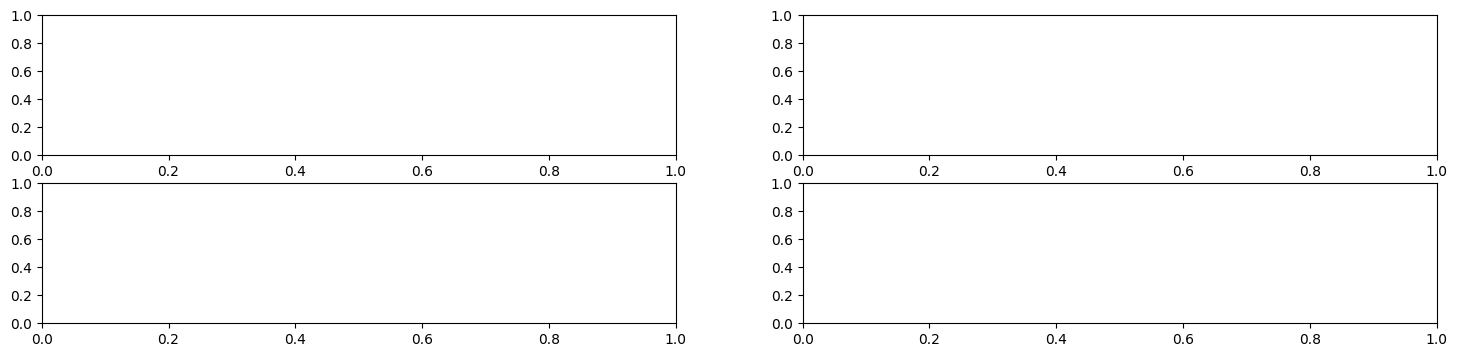

In [46]:
fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize=(18,4))
ax = axes.flatten()
for i, audio in enumerate(audio_dataset):
    print(i, audio[0].shape, label[1].shape)

    #plt.tight_layout()
    ax[i].set_title('Sample #{}'.format(i))
    #ax.axis('off')
    previous_audio, label = audio, label
    t_1 = np.linspace(0,2*temps_paquet,len(previous_audio))
    t_2 = np.linspace(2*temps_paquet,4*temps_paquet,len(label))
    ax[i].plot(t_1, previous_audio, 'b--')
    ax[i].plot(t_2, label, 'g--')

    if i == 3:
        plt.show()
        break

In [43]:
# problème : dans un même batch les audios sont liés
dataloader = DataLoader(audio_dataset, batch_size=6,
                        shuffle=True, num_workers=0)

In [44]:
def batch_audio_plot(sample_batched) : 
    previous_audio_batched, label_batched = sample_batched['previous_audio'], sample_batched['label']
    batch_size = len(previous_audio_batched)
    #im_size = images_batch.size(2)

    #plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        t_1 = np.linspace(0, 2*temps_paquet, len(previous_audio_batched[i]))
        t_2 = np.linspace(2*temps_paquet, 4*temps_paquet, len(label_batched[i]))
        plt.subplot(1,batch_size, i+1)
        plt.plot(t_1, previous_audio_batched[i])
        plt.subplot(1, batch_size, i+1)
        plt.plot(t_2, label_batched[i])
        plt.title('Batch from dataloader')

In [45]:
if __name__ == '__main__':
    for i_batch, sample_batched in enumerate(dataloader):
        print(i_batch, sample_batched['previous_audio'].size(),
            sample_batched['label'].size())
        # observe 4th batch and stop.
        if i_batch == 10:
            plt.figure()
            batch_audio_plot(sample_batched)
            plt.axis('off')
            plt.ioff()
            plt.show()
            break

TypeError: list indices must be integers or slices, not str

In [ ]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cpu device


In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(2*taille_paquet, 1024),
            nn.ReLU(),
            nn.Linear(1024, 640),
            nn.ReLU(),
            nn.Linear(640, taille_paquet),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=1280, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=640, bias=True)
    (3): ReLU()
    (4): Linear(in_features=640, out_features=640, bias=True)
  )
)


In [ ]:
train = model(dataloader)


NameError: name 'model' is not defined